# Dimensional Reduction: II

*N. Pol (2025)*

This lecture and notebook are based on the "DimensionReduction" and "DimensionReduction2" lectures of of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), which in turn are based on materials from Connolly, Leighly, VanderPlas, Geron, and Ivezic Ch. 7.

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 7.

---

## Contents
* [Non-linear Dimensional Reduction](#one)
* [Locally linear embedding (LLE)](#two)
* [Isometric mapping (IsoMap)](#three)
* [t-distributed Stochastic Neighbor Embedding (t-SNE)](#four)
* [Better Dataviz](#five)
    
---

***Exercises required for class participation are in <font color='red'>red</font>.***

---

## Non-linear Dimensional Reduction <a class="anchor" id="one"></a>

Today we will talk about the concepts of 
* manifold learning
* nonlinear dimensionality reduction

Specifically using the following algorithms
* locally linear embedding (LLE)
* isometric mapping (IsoMap)
* t-distributed Stochastic Neighbor Embedding (t-SNE)

A note of caution about the techniques you saw in the last lecture: PCA, NMF, and ICA are all linear methods. 

Astronomers will often try to derive physical insight from PCA eigenspectra or eigentimeseries, but there is no physical reason for the data to be linearly and orthogonally separable. Moreover, physical components are (generally) positive definite. So, PCA is great for dimensional reduction, but for doing physics there are generally better choices.

While NMF "solves" the issue of negative components, it is still a linear process. For data with non-linear correlations, an entire field, known as [Manifold Learning](http://scikit-learn.org/stable/modules/manifold.html) and [nonlinear dimensionality reduction]( https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction), has been developed, with several algorithms available via the [`sklearn.manifold`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold) module. 

For example, let's imagine your data set looks like this:

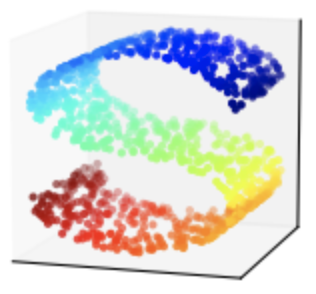

This is data drawn from an *S-shaped two-dimensional manifold embedded within three-dimensional space*. PCA is not going to know what to do with this because of the intrinsic non-linear structure. But let's give it a whirl; we get this:

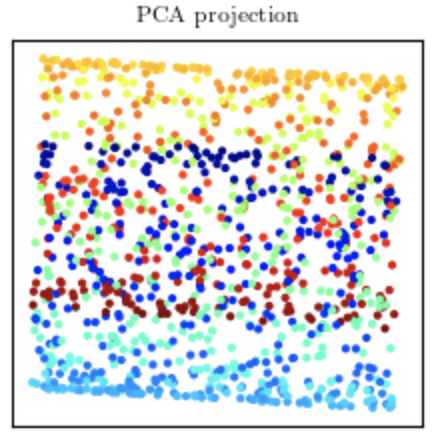

Clearly this is not helpful at all. There is no linear projection in which distant parts of the non-linear manifold do not overlap, resulting in the PCA projection mixing the colors.

***Manifold learning techniques*** on the other hand, do allow for this S-surface to be unwrapped so that its underlying structure is revealed. We'll look at some of these techniques today. Two techniques, **Locally linear embedding (LLE)** and **Isometric mapping (IsoMap)** show the power of these approaches:

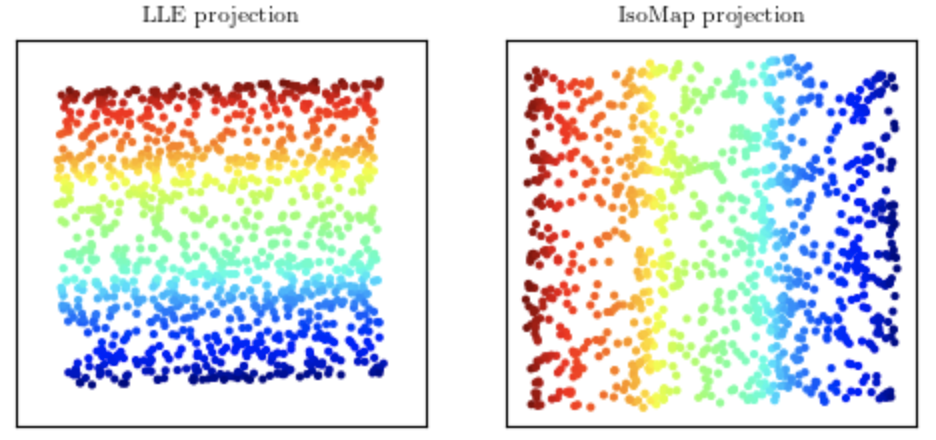

This is more like it! For more examples in astronomy see
[Vanderplas & Connolly 2009](http://iopscience.iop.org/article/10.1088/0004-6256/138/5/1365/meta;jsessionid=48A569862A424ECCAEECE2A900D9837B.c3.iopscience.cld.iop.org)

<font color='red'>Execute the cells below to reproduce this non-linear dimensional reduction of the S-shaped manifold.</font>

In [1]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

C:\Users\jeell\anaconda3\Lib\site-packages\astroML\linear_model\linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


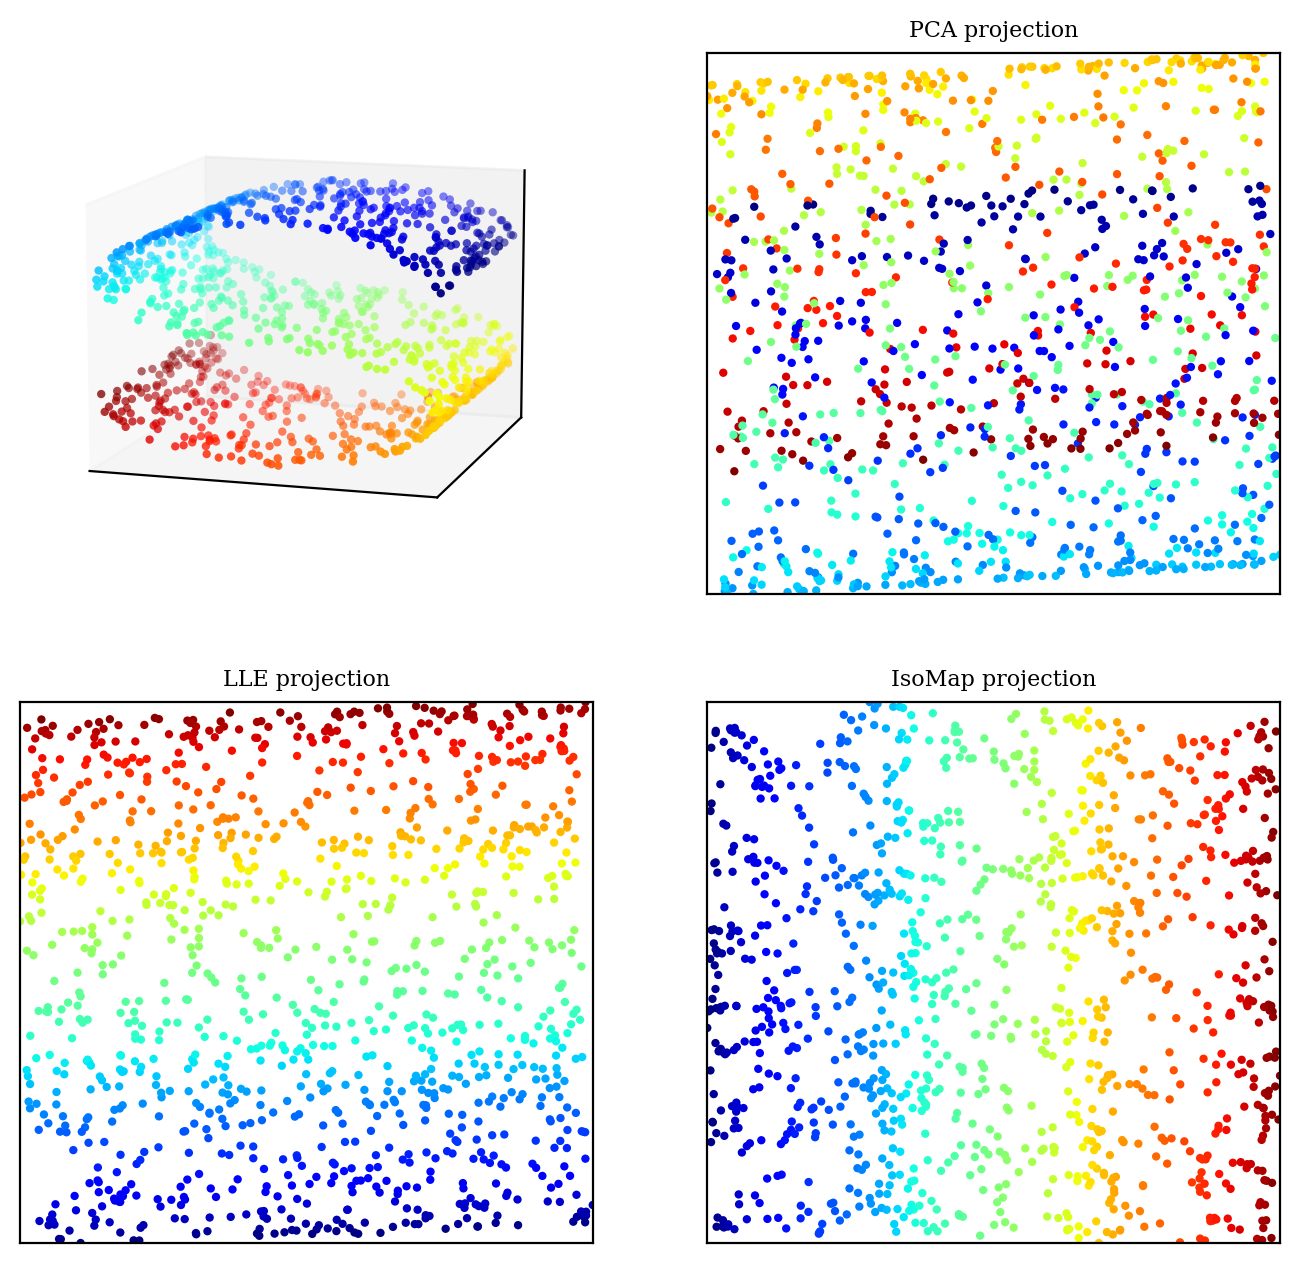

In [7]:
# Author: Jake VanderPlas
# Modified by SRT (2021)
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from matplotlib import ticker
from sklearn import manifold, datasets, decomposition

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# generate the S-curve dataset
np.random.seed(0)

n_points = 1100
n_neighbors = 10
out_dim = 2

X, color = datasets.make_s_curve(n_points)

# change the proportions to emphasize the weakness of PCA
X[:, 1] -= 1
X[:, 1] *= 1.5
X[:, 2] *= 0.5

#------------------------------------------------------------
# Compute the projections
pca = decomposition.PCA(out_dim)
Y_pca = pca.fit_transform(X)

lle = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, 
                                      n_components=out_dim, 
                                      method='modified', random_state=0, 
                                      eigen_solver='dense')
Y_lle = lle.fit_transform(X)

iso = manifold.Isomap(n_neighbors=n_neighbors, 
                      n_components=out_dim)
Y_iso = iso.fit_transform(X)

#------------------------------------------------------------
# plot the 3D dataset
fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(left=0.05, right=0.95,
                    bottom=0.05, top=0.9)
try:
    # matplotlib 1.0+ has a toolkit for generating 3D plots
    from mpl_toolkits.mplot3d import Axes3D
    ax1 = fig.add_subplot(221, projection='3d',
                          xticks=[], yticks=[], zticks=[])
    ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=color,
                cmap=plt.cm.jet, s=9, lw=0)
    ax1.view_init(11, -73)

except:
    # In older versions, we'll have to wing it with a 2D plot
    ax1 = fig.add_subplot(221)

    # Create a projection to mimic 3D scatter-plot
    X_proj = X / (X.max(0) - X.min(0))
    X_proj -= X_proj.mean(0)
    R = np.array([[0.5, 0.0],
                  [0.1, 0.1],
                  [0.0, 0.5]])
    R /= np.sqrt(np.sum(R ** 2, 0))
    X_proj = np.dot(X_proj, R)

    # change line width with depth
    lw = X[:, 1].copy()
    lw -= lw.min()
    lw /= lw.max()
    lw = 1 - lw

    ax1.scatter(X_proj[:, 0], X_proj[:, 1], c=color,
                cmap=plt.cm.jet, s=9, lw=lw, zorder=10)

    # draw the shaded axes
    ax1.fill([-0.7, -0.3, -0.3, -0.7, -0.7],
             [-0.7, -0.3, 0.7, 0.3, -0.7], ec='k', fc='#DDDDDD', zorder=0)
    ax1.fill([-0.3, 0.7, 0.7, -0.3, -0.3],
             [-0.3, -0.3, 0.7, 0.7, -0.3], ec='k', fc='#DDDDDD', zorder=0)
    ax1.fill([-0.7, 0.3, 0.7, -0.3, -0.7],
             [-0.7, -0.7, -0.3, -0.3, -0.7], ec='k', fc='#DDDDDD', zorder=0)

    ax1.xaxis.set_major_locator(ticker.NullLocator())
    ax1.yaxis.set_major_locator(ticker.NullLocator())

#------------------------------------------------------------
# Plot the projections
subplots = [222, 223, 224]
titles = ['PCA projection', 'LLE projection', 'IsoMap projection']
Yvals = [Y_pca, Y_lle, Y_iso]

for (Y, title, subplot) in zip(Yvals, titles, subplots):
    ax = fig.add_subplot(subplot)
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.jet, s=9, lw=0)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Locally Linear Embedding (LLE) <a class="anchor" id="two"></a>

[Local Linear Embedding](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding) attempts to embed high-$D$ data in a lower-$D$ space.  Crucially it also seeks to preserve the geometry of the local "neighborhoods" around each point.  In the case of the "S" curve, it seeks to unroll the data.  The steps are

**STEP 1:** *define the local geometry*
- local neighborhoods are determined from each point's $k$ nearest neighbors.
- for each point calculate the weights that reconstruct a point from its $k$ nearest neighbors via
$$ \mathcal{E}_1(W) = \left|X - WX\right|^2,$$
where $X$ is an $N\times K$ matrix and $W$ is an $N\times N$ matrix that minimizes the reconstruction error.

Essentially this is **finding the hyperplane that describes the local surface at each point** within the data set. So, imagine that you have a bunch of square tiles and you are trying to tile the surface with them. 

One trivial solution of the above equation is $W=I$ where $I$ is an identity matrix-- however this can be avoided by constraining $W_{ii}=0$ for all points, $i$. The resulting constrained solution to $W$ is far more interesting, encoding the global geometry of the manifold through each point's relation to all others. 

- take the constrained solution a step further by setting all $W_{ij}=0$ except when point $j$ is one of the $k$ nearest neighbors of point $i$. 

Each row of $W$ encodes the local geometry of each point, and the matrix as a whole encodes the global geometry of the manifold.

**STEP 2:** *embed within a lower dimensional space* 
- $W$ becomes very sparse for $k \ll N$ (only $Nk$ entries in $W$ are non-zero). 
- minimize
$$ \mathcal{E}_2(Y) = \left|Y - W Y\right|^2,$$
with $W$ fixed to find an $N$ by $d$ matrix ($d$ is the new dimensionality).

This final step corresponds to finding a lower dimensional embedding of the data, $Y$, that reflects the geometry of the local neighborhoods in the original data matrix, $X$.

***Step 1 requires a nearest-neighbor search. Step 2 requires an eigenvalue decomposition of the matrix $C_W \equiv (I-W)^T(I-W)$.*** 

LLE has been applied to data as diverse as galaxy spectra, stellar spectra, and photometric light curves. It was introduced by [Roweis & Saul (2000)](https://www.ncbi.nlm.nih.gov/pubmed/11125150). Roweis has some fun examples on his website, including an LLE of a twin peaked surface, reduced down to a lower dimension:

![](https://cs.nyu.edu/home/people/in_memoriam/roweis/lle/images/llemovg22.gif)

An even more interesting example is an LLE analysis of face images. By unwrapping many images into vectors of pixels and stacking to form a data matrix, LLE can be used to discriminate facial expressions:

![](https://cs.nyu.edu/home/people/in_memoriam/roweis/lle/images/tfiga.gif)

Scikit-learn's call to LLE is as follows, with a more detailed example already being given above.

In [17]:
from sklearn.manifold import LocallyLinearEmbedding

X = np.random.normal(size=(1000,2)) # 1000 points in 2D
R = np.random.random((2,10)) # projection matrix
X = np.dot(X,R) # now a 2D linear manifold in 10D space

k = 5 # Number of neighbors to use in fit
n = 2 # Number of dimensions to fit

lle = LocallyLinearEmbedding(n_neighbors=k, 
                             n_components=n)
lle.fit(X)
proj = lle.transform(X) # 100x2 projection of the data

<font color='red'>See what LLE does for the digits data, using the 7 nearest neighbors and 2 components.</font>

In [19]:
# Execute this cell to load the digits sample
from sklearn.datasets import load_digits

digits = load_digits()
grid_data = np.reshape(digits.data[0], (8,8)) #reshape to 8x8
plt.imshow(grid_data, interpolation = "nearest", cmap = "bone_r")
print(grid_data)
X = digits.data
y = digits.target

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


In [21]:
# LLE
from sklearn.manifold import LocallyLinearEmbedding
k = 7 # Number of neighbors to use in fit
n = 2 # Number of dimensions to fit
lle = LocallyLinearEmbedding(n_neighbors=k,
                             n_components=n)
lle.fit(X)
X_reduced = lle.transform(X)

plt.scatter(X_reduced[:,0], X_reduced[:,1], 
            c=y, cmap="nipy_spectral", edgecolor="None")
plt.colorbar()

## Isometric Mapping (IsoMap) <a class="anchor" id="three"></a>

**IsoMap** is based on the multi-dimensional scaling (MDS) framework. Classical MDS recovers a data set from the matrix of pairwise distances between points. 

IsoMap was coincidentally introduced in the same volume of *Science* as the LLE article above. See [Tenenbaum, de Silva, & Langford (2000)](https://www.ncbi.nlm.nih.gov/pubmed/?term=A+Global+Geometric+Framework+for+Nonlinear+Dimensionality+Reduction).

***IsoMap seeks to find a lower dimensional embedding of the data marix that maintains the geodesic distances between all points.*** Rather than using Euclidean distances between points, IsoMap actually approximates geodesic curves that lie in the embedded manifold, then **computes the distances between each point in the data set along these geodesics**. This can be seen in the image below from Tenenbaum et al.-- the dataset is a ["Swiss Roll"](https://www.wikiwand.com/en/Swiss_roll). 

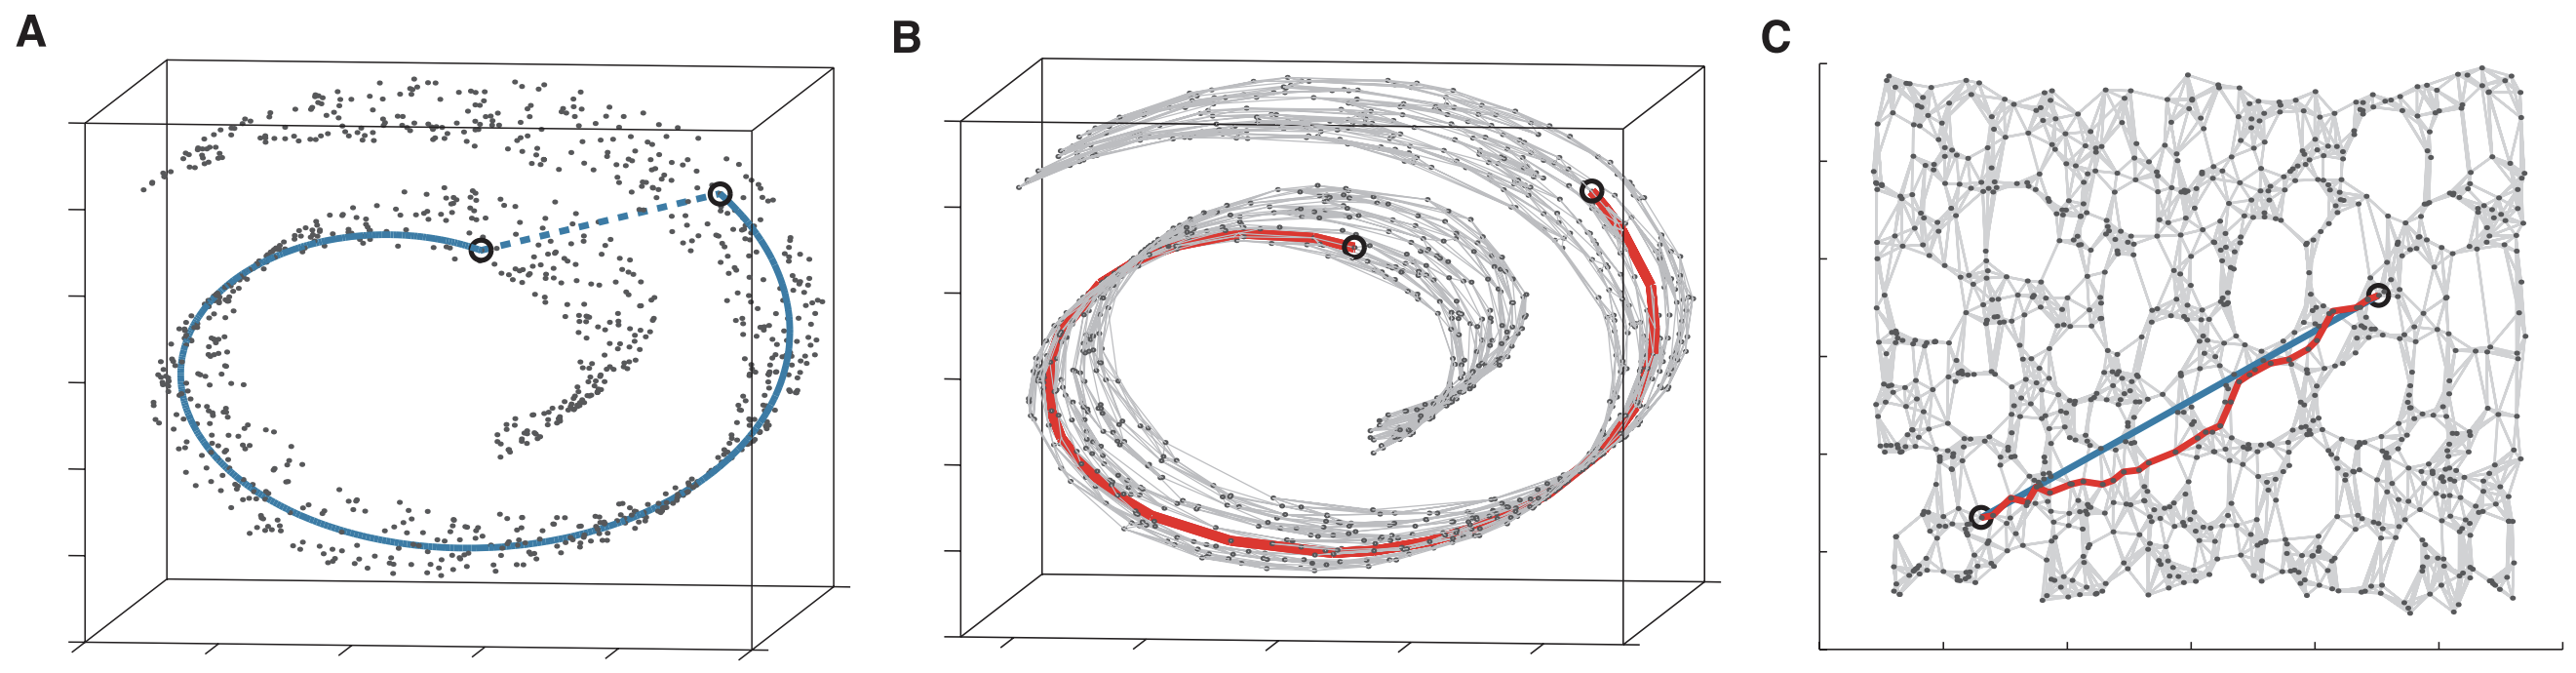


- In the **left panel**, one can see that the Euclidean distance between two points (dashed line) is not a true reflection of how far apart they are on the embedded manifold (solid line). 
- In the **middle panel**, a [neighboorhood graph](https://www.wikiwand.com/en/Neighbourhood_(graph_theory)) is constructed that connects each point to its neighboors, allowing the geodesic distance between points to be computed by finding the shortest path through the graph.
- In the **right panel**, a lower dimensional embedding of the manifold is recovered by IsoMap that preserves the relative geodesic distances between points.

For the final step of finding the optimal low-dimensional embedding, MDS algorithm technqiues are used to minimize the reconstruction error:

$$ \mathcal{E}_{XY} = |\tau(D_X) - \tau(D_Y)|^2 $$

between the original data set $X$ and the low-dimensional embedding $Y$, where $\tau$ is some operator on the distance matrices.

In Scikit-Learn [IsoMap](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html) is implemented as follows:

In [23]:
# Execute this cell
from sklearn.manifold import Isomap

XX = np.random.normal(size=(1000,2)) # 1000 points in 2D
R = np.random.random((2,10)) # projection matrix
XX = np.dot(XX,R) # X is a 2D manifold in 10D space

k = 5 # number of neighbors
n = 2 # number of dimensions

iso = Isomap(n_neighbors=k, n_components=n)
iso.fit(XX)
proj = iso.transform(XX) # 1000x2 projection of the data

<font color='red'>Try 7 neighbors and 2 dimensions on the digits data.</font>

In [25]:
# IsoMap
k = 7 # Number of neighbors to use in fit
n = 2 # Number of dimensions to fit

iso = Isomap(n_neighbors=k,
             n_components=n)
iso.fit(X)

X_reduced = iso.transform(X)

plt.scatter(X_reduced[:,0], X_reduced[:,1], 
            c=y, cmap="nipy_spectral", edgecolor="None")
plt.colorbar()

## t-distributed Stochastic Neighbor Embedding (t-SNE) <a class="anchor" id="four"></a>

**[t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)** is not discussed in the book, but Scikit-Learn does have a [t-SNE implementation](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), and it is well worth mentioning this powerful manifold learning algorithm too. 

SNE itself was developed by [Hinton & Roweis](http://www.cs.toronto.edu/~fritz/absps/sne.pdf) with the "$t$" part being added by [van der Maaten & Hinton](http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf). It works like the other manifold learning algorithms. To give you an idea of how cutting edge this is compared to other techniques we've seen, t-SNE was only published in $2008$. PCA dates from $1933$; alot has changed in computational physics since then.

> [t-SNE differs from PCA by preserving only small pairwise distances or local similarities whereas PCA is concerned with preserving large pairwise distances to maximize variance.](https://medium.com/@violante.andre/an-introduction-to-t-sne-with-python-example-47e6ae7dc58f)

A high-level description of the steps in t-SNE are as follows:

**STEP 1**: *measure the similarity between points in the original high-dimensional space*
- this is done by centering a multivariate Gaussian on each point and measuring the pdf value of all neighboors.
- the bandwidth of the Gaussian can be chosen to tweak something called the *perplexity*, which essentially relates to the number of nearest neighboors being considered.
- the result is a matrix of probabilities of each point under a Gaussian centered under every other point, $p_{ij}$.
- this "similarity matrix" is a measure of local structure.

**STEP 2**: *find a lower-dimensional mapping that preserves the similarities, $p_{ij}$*
- a heavy-tailed Student's $t$-distribution with $1$-degree of freedom (i.e. a Cauchy distribution) is used to model the probabilities between pairs of points in the low-dimensional embedding, $q_{ij}$.
- this allows dissimilar objects to be modeled as being far apart on the map. 
- A quantity known as the [Kullback-Leibler divergence](https://www.wikiwand.com/en/Kullback%E2%80%93Leibler_divergence) is used to minimize differences between $p_{ij}$ and $q_{ij}$. 

<font color='red'>Try it on the digits data. You'll need to import `TSNE` from `sklearn.manifold`, instantiate it with 2 components, then do a `fit_transform` on the original data.</font>

In [31]:
# t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,learning_rate=200)
X_reduced = tsne.fit_transform(X)

plt.scatter(X_reduced[:,0], X_reduced[:,1], 
            c=y, cmap="nipy_spectral", alpha=0.3, 
            edgecolor="None")
plt.colorbar()

You'll know you've done it right if you find your eyebrows shooting upwards!

What's even more illuminating is to make the plot using the actual digits to plot the points.  Then you can see why certain digits are alike or split into multiple regions.  Can you explain the patterns you see here?

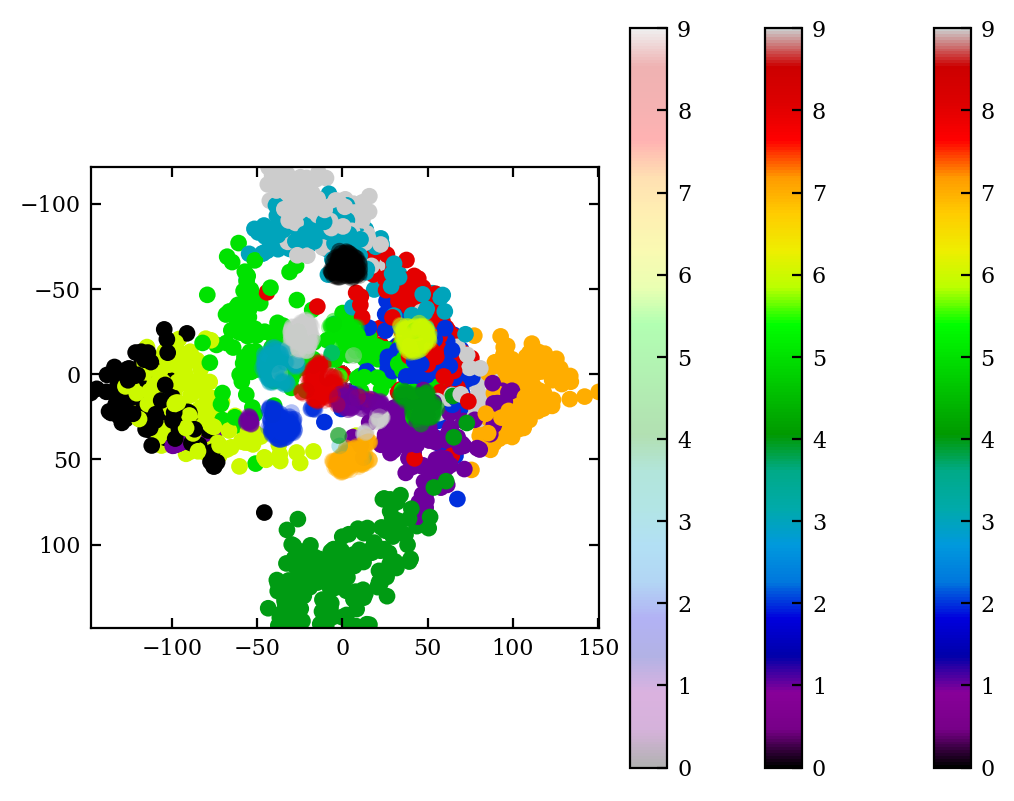

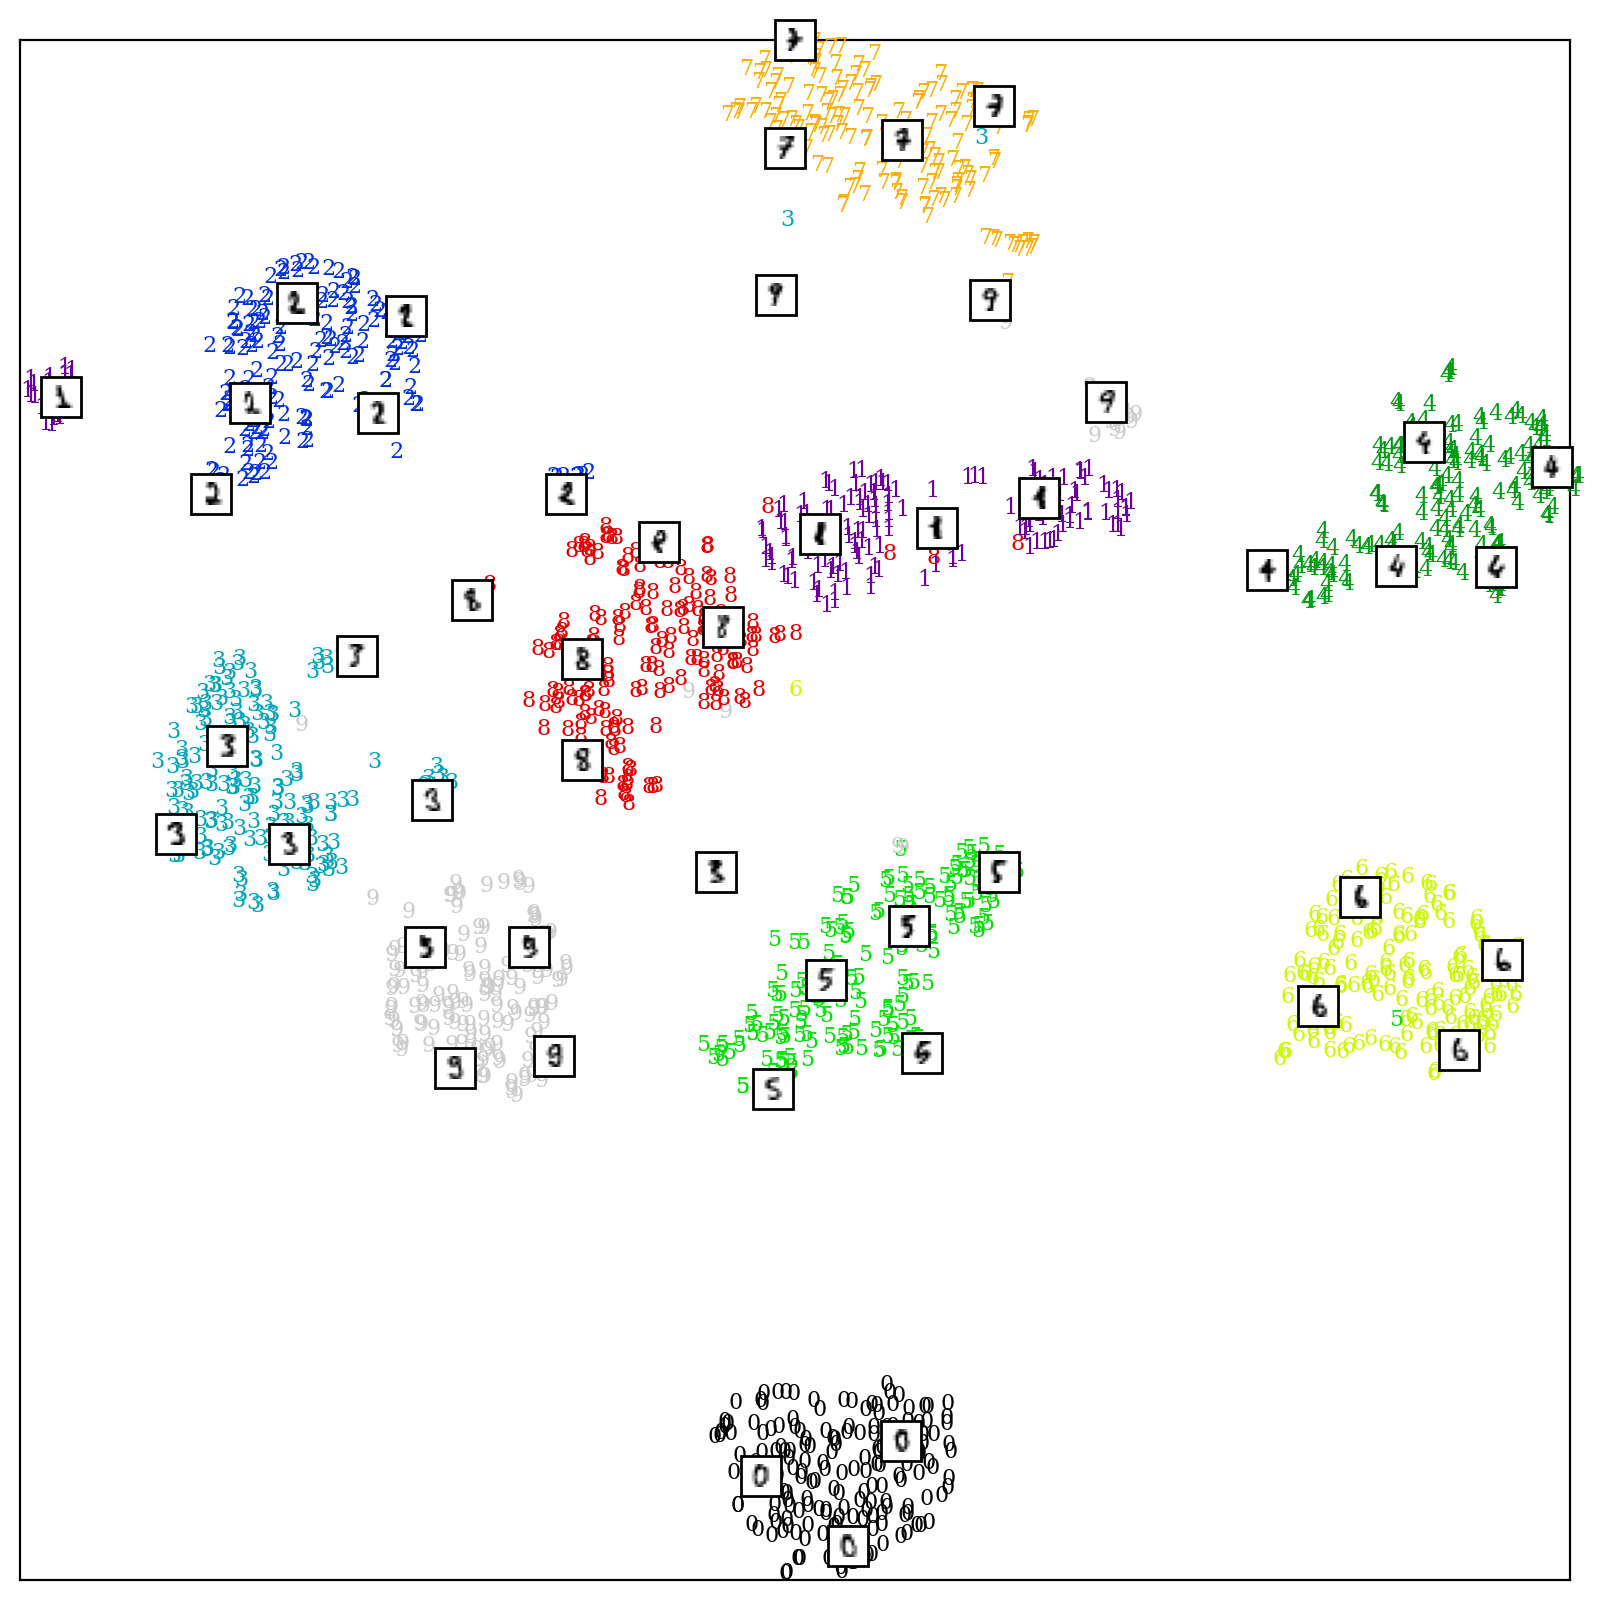

In [33]:
# Execute this cell
from matplotlib import offsetbox

#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]), 
                 color=plt.cm.nipy_spectral(y[i]/9.))

    shown_images = np.array([[1., 1.]])  # just something big
    for i in range(digits.data.shape[0]):
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.r_[shown_images, [X[i]]]
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i],
                                  cmap=plt.cm.gray_r), 
            X[i])
        ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    
plot_embedding(X_reduced)
plt.show()

I mean, is this cool or what?!

One other reason why t-SNE is so powerful is that while Isomap, LLE and variants are best suited to unfold a single continuous low-dimensional manifold, t-SNE groups samples based on the local structure. So it can be used to unwrap and disentangle a dataset that comprises several manifolds at once (as is the case in the digits dataset). See [here](https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne) for more details.

Here is another fun example of **t-SNE used to visualize one realization of the Netflix catalog** (from https://lvdmaaten.github.io/tsne/). So if you have trouble finding something to watch, look here for something you already enjoy then check out its neighboors.

![](https://lvdmaaten.github.io/tsne/examples/netflix_tsne.jpg)

## Better Dataviz <a class="anchor" id="five"></a>

We often use dimensionality reduction to help with data visualization, so it seems appropriate to briefly talk about some different ways to improve our data visualization using plotting tools. 

The first example is the [seaborn.pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html). It is essentially a corner plot with both upper and lower triangles shown, and with the pairwise correlations exhibited as scatter plots.

In [35]:
!pip install seaborn

In [37]:
import seaborn as sns
penguins = sns.load_dataset("penguins")
sns.pairplot(penguins)

The second example is an illustration of the power of [Bokeh](https://bokeh.org/), a language to create interacte browser-based dashboards for data visualization. The following two code cells will install bokeh, then create and launch a new browser tab (chrome for me) that shows a set of interactive scatter plots for the penguin data set. This uses the data-visualization principles of [**brushing & linking**](https://www.wikiwand.com/en/Brushing_and_linking).

- ***Linking*** refers to having a connected series of data representations (e.g. histograms or scatter plots), where a change in one parameter or a subset of parameters in one representation is then reflected in the others.
- ***Brushing*** refers to highlighting subsets of data within one representation such that this subset is also highlighted in its other representations through the linked view.

<font color='red'>Play around with the lasso data selection tool in the bokeh dashboard to see what this means.</font>

In [39]:
!pip install bokeh

In [55]:
from bokeh.plotting import *
from bokeh.models import ColumnDataSource

# prepare some data
N = 300
x0 = penguins['bill_depth_mm']
x1 = penguins['flipper_length_mm']
y = penguins['body_mass_g']
species = penguins['species']

# output to static HTML file
output_file("linked_brushing.html")

# NEW: create a column data source for the plots to share
source = ColumnDataSource(data=dict(x0=x0, x1=x1, 
                                    y=y, species=species))

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select,lasso_select"

TOOLTIPS = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
    ("species", "@species"),
]

# create a new plot and add a renderer
left = figure(tools=TOOLS, tooltips=TOOLTIPS, 
              width=350, height=350, title=None,
              x_axis_label ="bill_depth_mm",
              y_axis_label ="body_mass_g")
left.circle('x0', 'y', size = 4, source=source)

# create another new plot and add a renderer
right = figure(tools=TOOLS, tooltips=TOOLTIPS, 
               width=350, height=350, title=None,
              x_axis_label ="flipper_length_mm",
               y_axis_label ="body_mass_g")
right.circle('x1', 'y', size = 4, source=source)

# put the subplots in a gridplot
p = gridplot([[left, right]])

# show the results
show(p,browser="C:\\Program Files (x86)\\Microsoft\\Edge\\Application\\msedge.exe %s")

Finally for today -- if irises, penguins, or hand-written digits aren't your thing, then have a look through some of these public data repositories:

- [https://github.com/caesar0301/awesome-public-datasets?utm_content=buffer4245d&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer](https://github.com/caesar0301/awesome-public-datasets?utm_content=buffer4245d&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer)
- [http://www.datasciencecentral.com/m/blogpost?id=6448529%3ABlogPost%3A318739](http://www.datasciencecentral.com/m/blogpost?id=6448529%3ABlogPost%3A318739)
- [http://www.kdnuggets.com/2015/04/awesome-public-datasets-github.html](http://www.kdnuggets.com/2015/04/awesome-public-datasets-github.html)

Finally, here is another great tool for non-linear dimensional reduction called [UMAP](https://umap-learn.readthedocs.io/en/latest/). Check out the [UMAP Zoo](https://duhaime.s3.amazonaws.com/apps/umap-zoo/index.html)!

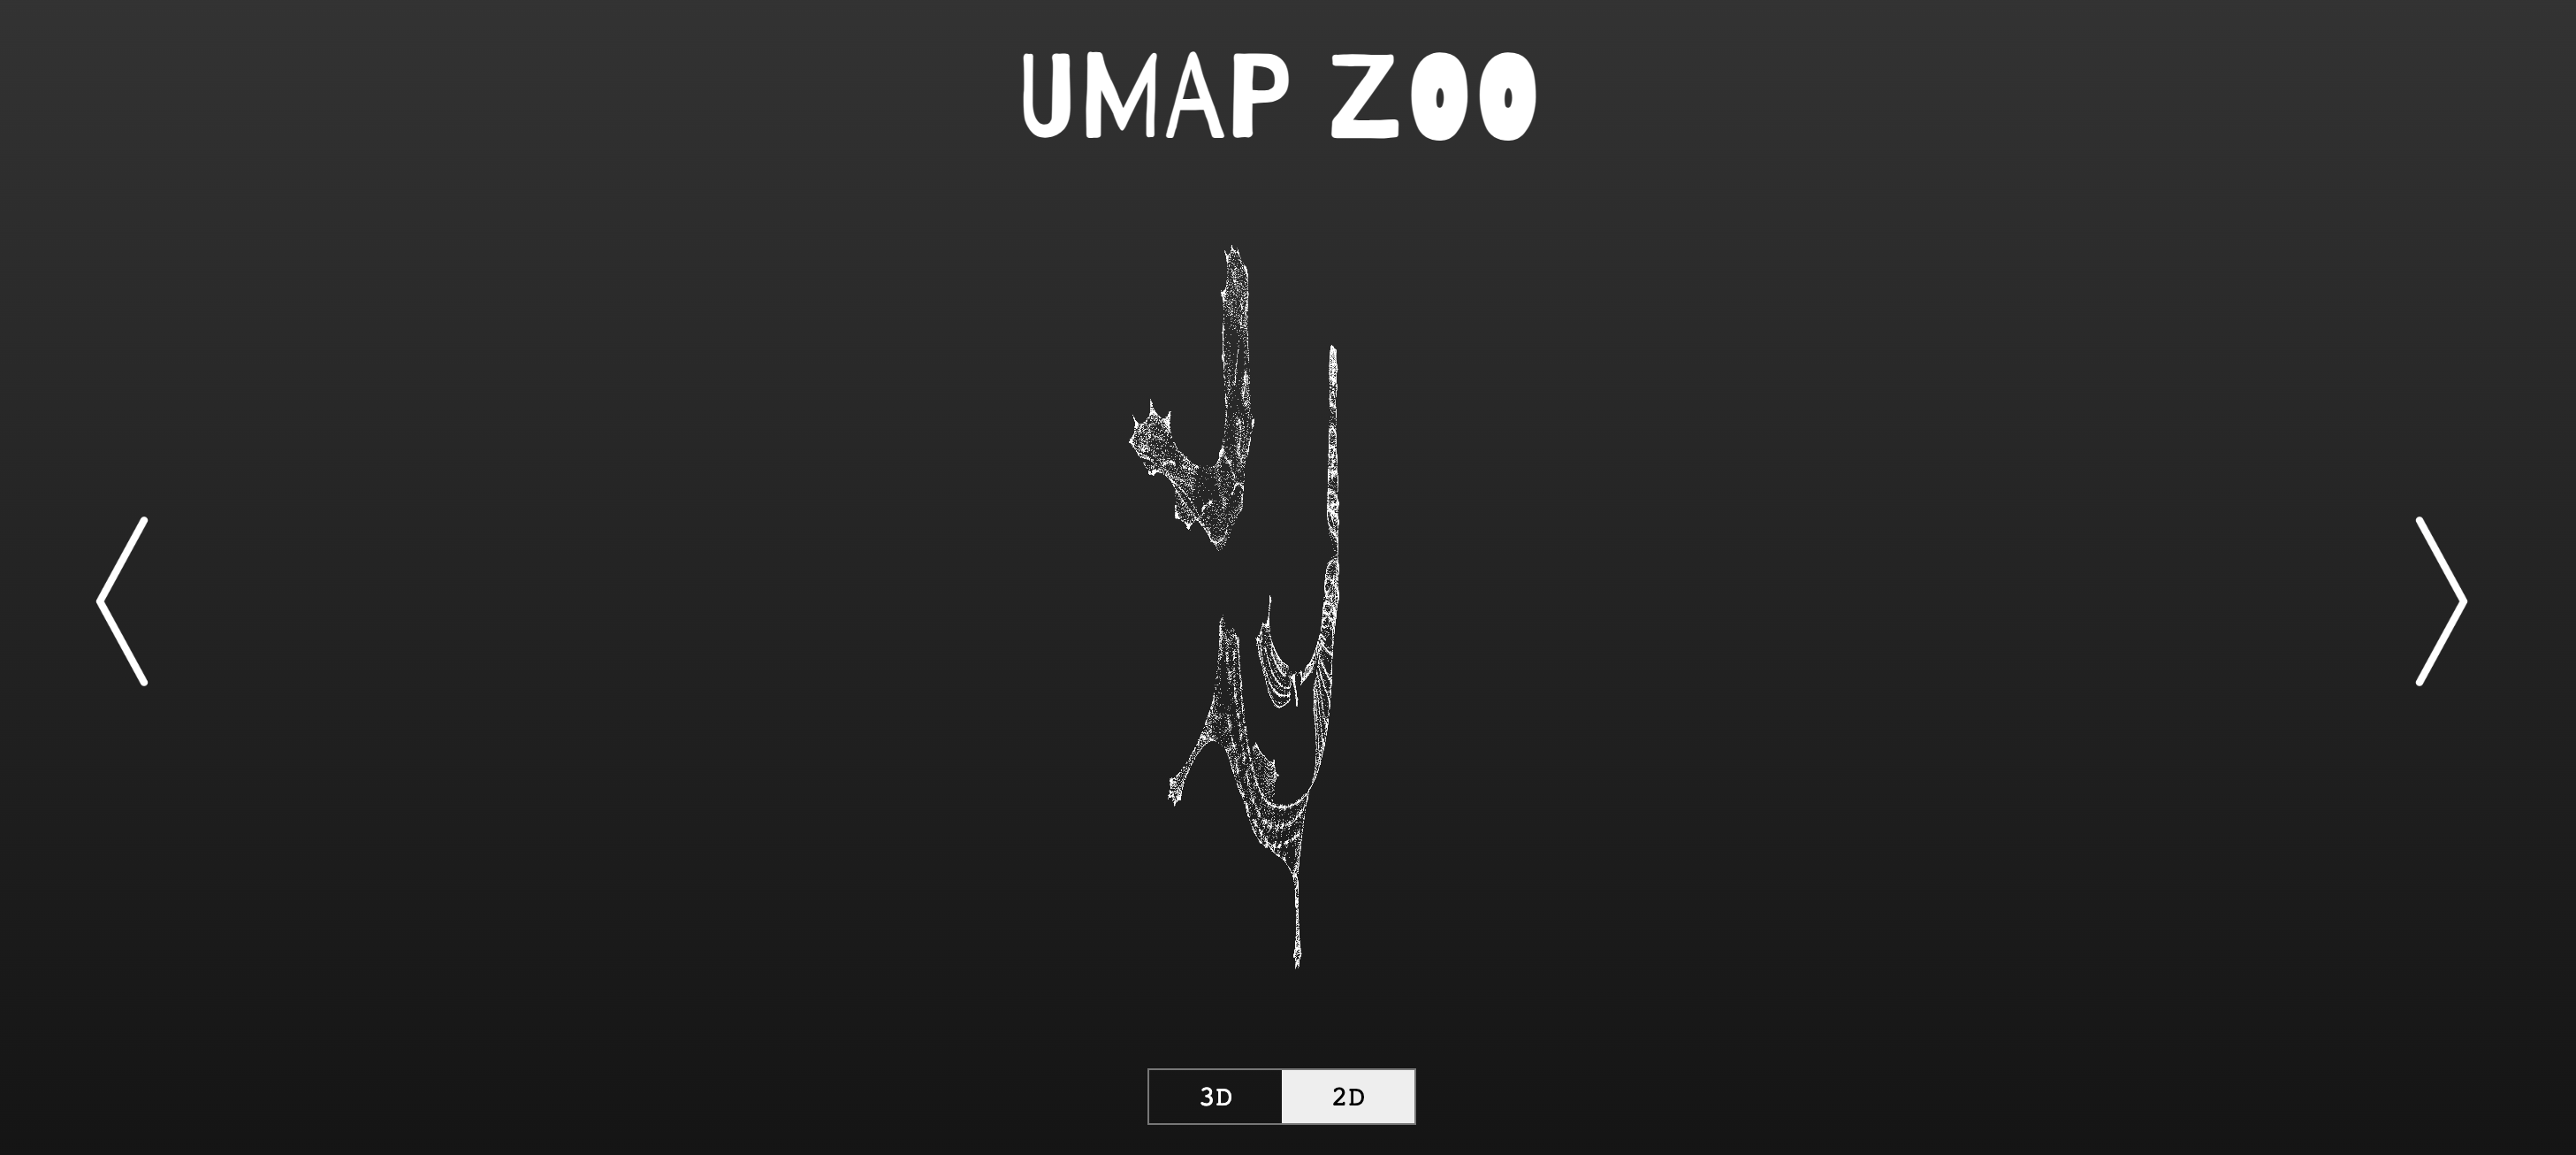